In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import numpy as np
from tsquared import HotellingT2, MYTDecomposition
from unravel import *
#information gain
#from sklearn.feature_selection import mutual_info_classif
# Bayesian
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, BicScore, TreeSearch
from pgmpy.models import BayesianNetwork

In [7]:
import pyreadr
train_normal_path = 'TEP2017R/TEP_FaultFree_Training.RData'
train_faulty_path =  'TEP2017R/TEP_Faulty_Training.RData'
 
test_normal_path = 'TEP2017R/TEP_FaultFree_Testing.RData'
test_faulty_path = 'TEP2017R/TEP_Faulty_Testing.RData'
 
train_normal = pyreadr.read_r(train_normal_path)['fault_free_training']
train_faulty = pyreadr.read_r(train_faulty_path)['faulty_training']
test_normal = pyreadr.read_r(test_normal_path)['fault_free_testing']
test_faulty = pyreadr.read_r(test_faulty_path)['faulty_testing']

In [9]:
print(train_normal.columns)

Index(['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2',
       'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'],
      dtype='object')


In [78]:
# TEP truths
faultToRoot = {1:'xmeas_4', 4:'xmeas_9', 5:'xmeas_22', 6:'xmeas_1', 11:'xmeas_21', 12:'xmeas_11', 14:'xmeas_9', 15:'xmeas_11'}
faultToVariables = {1:['xmeas_1', 'xmeas_4', 'xmeas_18', 'xmeas_21', 'xmeas_25', 'xmeas_26'],
                    14:['xmeas_9', 'xmeas_11', 'xmeas_21', 'xmeas_32']}

xmeas_4


In [8]:
# only keep continuous variables, xmeas_1 - xmeas_22
df_train_normal = train_normal[train_normal.simulationRun==1].iloc[:,3:25]
df_train_faulty = train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==1)].iloc[:,3:25]
df_test_normal = test_normal[test_normal.simulationRun==1].iloc[:,3:25]
df_train_normal.head()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,2632.9,25.029,50.528,3101.1,22.819,65.732,229.61,341.22,94.640,77.047
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,2633.8,24.419,48.772,3102.0,23.333,65.716,230.54,341.30,94.595,77.434
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,2635.5,25.244,50.071,3103.5,21.924,65.732,230.08,341.38,94.605,77.466
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,2635.6,23.268,50.435,3102.8,22.948,65.781,227.91,341.71,94.473,77.443
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,2632.4,26.099,50.480,3103.5,22.808,65.788,231.37,341.11,94.678,76.947


In [17]:
# PCA
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
kComponents = 2
pca = PCA(kComponents)
ss = StandardScaler()
x = ss.fit_transform(df_train_normal)
pca.fit(x)

PCA(n_components=2)

In [75]:
def displayComponentStatistics(data, pca_model, kComponents):
    name = list(df_train_normal.columns)
    score = abs(pca.components_)
    print(sorted(zip(score[0], name), reverse=True)[:kComponents])
    print(sorted(zip(score[1], name), reverse=True)[:kComponents])
    print(np.sum(pca.explained_variance_ratio_[:kComponents]))

def hotelling_t_squared(data, pca_model):
    # Transform data into principal component space
    transformed_data = pca_model.transform(data)
    
    # Calculate centroid in principal component space
    centroid = np.mean(transformed_data, axis=0)
    
    # Calculate Mahalanobis distance (T^2 score) for each sample
    t_squared_scores = np.sum((transformed_data - centroid)**2 / pca_model.explained_variance_, axis=1)
    return t_squared_scores

#doesn't work
def calculate_cdc_score(data, pca_model, faulty_indices):
    # Transform data into principal component space
    transformed_data = pca_model.transform(data)
    
    # Extract relevant components and covariance matrix
    principal_components = pca_model.components_
    covariance_matrix = np.cov(transformed_data.T)
    
    # Calculate CDC scores for each faulty instance and each variable
    cdc_scores = []
    for idx in faulty_indices:
        t_squared_instance = transformed_data[idx]
        cdc_score_instance = np.zeros(len(principal_components))
        for i in range(len(principal_components)):
            contribution = np.dot(principal_components[i], np.dot(np.linalg.inv(covariance_matrix), principal_components[i].T))
            normalized_contribution = contribution / np.sum(contribution)
            cdc_score_instance[i] = normalized_contribution * t_squared_instance[i] ** 2
        cdc_scores.append(cdc_score_instance)
    return np.array(cdc_scores)

def top_ten_vars(df, pca_model):
    name = list(df.columns)
    score = abs(pca_model.components_)
    variables = set()
    for i in sorted(zip(score[0], name), reverse=True)[:5]:
        variables.add(i[1])
    for i in sorted(zip(score[1], name), reverse=True)[:5]:
        variables.add(i[1])
    variables = list(variables)
    return variables

# Freedman-Diaconis rule
def equal_width_bin(df):
    # df = df[df.simulationRun==1].iloc[:,3:25]
    # normalize dataframe
    df = (df - df.mean())/df.std()
    n = df.shape[0]
    for col in list(df.columns):
        c = df[col]
        num_bins = math.ceil((c.max() - c.min()) / (2 * (c.quantile(0.75) - c.quantile(0.25)) / (n**(1/3))))
        df[col] = pd.cut(df[col], bins=num_bins, labels=False)
    return df

#mean contribution threshold
def MCTvariables(contributions, t2_scores):
    # contributions: m x n, where m is number of samples, n is number of variables
    n = len(contributions[0])
    m = len(contributions)
    minFrequency = m * 0.05
    count = [0]*n
    variables = []
    for i in range(m):
        # change 50
        if t2_scores[i] > 50:
            contribution = contributions[i]
            mean = sum(contribution)/n
            for j in range(n):
                if contribution[j] > mean:
                    count[j] += 1
    for i in range(n):
        if count[i] > minFrequency:
            variables.append(i)
    return variables

In [83]:
from scipy.stats import chi2

# Obtain the threshold value from the Chi-squared distribution
threshold = chi2.ppf(0.95, kComponents)

print("Threshold for T^2 statistic (95% significance level):", threshold)

Threshold for T^2 statistic (95% significance level): 5.991464547107979


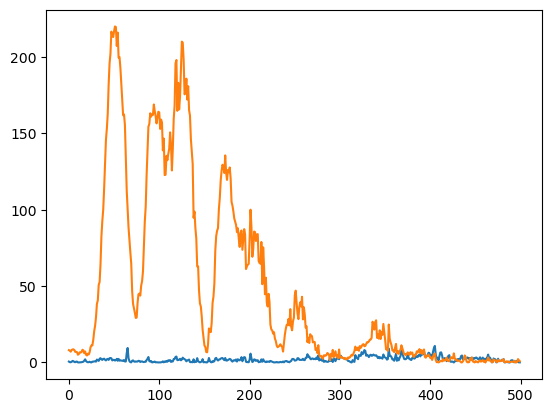

In [19]:
t_squared_scores = hotelling_t_squared(x, pca)
plt.plot(t_squared_scores)

x_2 = ss.transform(df_train_faulty,copy=None)
t_squared_scores = hotelling_t_squared(x_2, pca)
plt.plot(t_squared_scores)

[0, 2, 3, 7, 10, 18, 19]
[0, 6, 10, 12, 15, 18, 19]


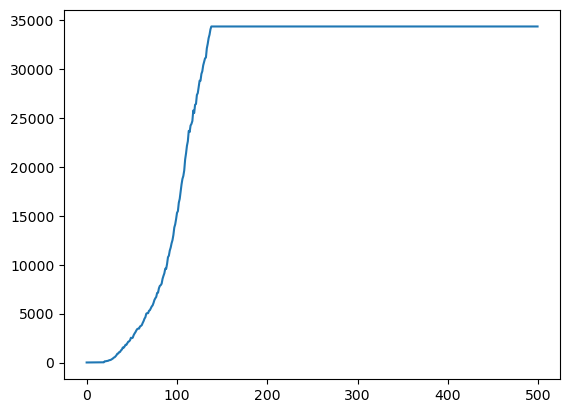

In [80]:
x2 = train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==6)].iloc[:,3:25]

hotelling = HotellingT2().fit(df_train_normal)
t2_scores = hotelling.score_samples(x2)
plt.plot(t2_scores)

myt_dec = MYTDecomposition(hotelling)
uncond_t2_terms = myt_dec.unconditional_t2_terms(x2)
uncond_ucl = myt_dec.ucl_unconditional_terms()
cond_t2_terms = myt_dec.conditional_t2_terms(x2)
cond_ucl = myt_dec.ucl_conditional_terms()
# condition yields less variables, so use condition for now
variables = MCTvariables(cond_t2_terms, t2_scores)
print(MCTvariables(cond_t2_terms, t2_scores))
print(MCTvariables(uncond_t2_terms, t2_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

21


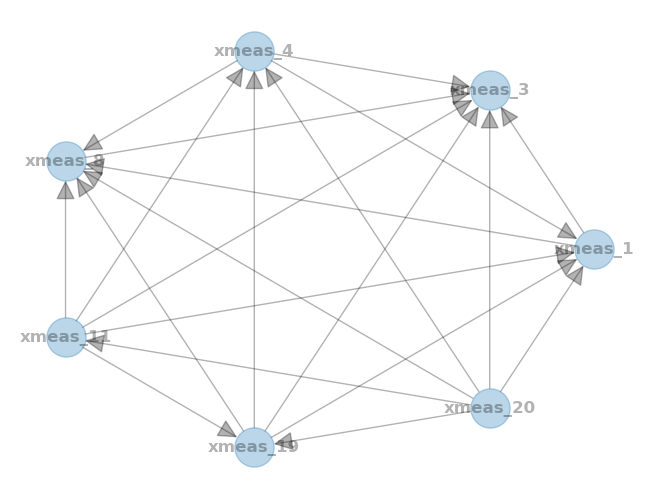

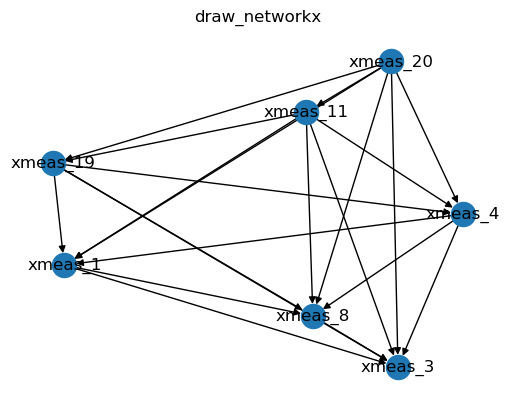

In [81]:
#fault = equal_width_bin(fault)
#fault7 = train_faulty[(train_faulty.simulationRun<10) & (train_faulty.faultNumber==7)]
#variables = ['xmeas_1', 'xmeas_4', 'xmeas_7', 'xmeas_8', 'xmeas_10', 'xmeas_20']
#variables = ['xmeas_9', 'xmeas_18', 'xmeas_20', 'xmeas_22']
#fault7 = equal_width_bin(fault7[variables])
fault = x2.iloc[:,variables]

# learn graph structure
est = HillClimbSearch(fault)
best_model = est.estimate(max_iter=100)
print(len(best_model.edges()))
nx.draw_circular(
    best_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
write_dot(best_model,'test.dot')

# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos =graphviz_layout(best_model, prog='dot')
nx.draw(best_model, pos, with_labels=True, arrows=True)
plt.savefig('nx_test.png')

In [45]:
"""
# PC estimator, outputs a very low number of variables
from pgmpy.estimators import PC
est = PC(equal_width_bin(df_train_faulty.iloc[:, variables]))
# 0.001 has 2 edges df_train_normal[variables]
model_chi = est.estimate(significance_level=0.01)
print(len(model_chi.edges()))
nx.draw_circular(
    model_chi, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

# Funtion to evaluate the learned model structures. Not useful since we don't know the actual structure.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_array(
        estimated_model.to_undirected(), nodelist=nodes, weight=None
    )
    true_adj = nx.to_numpy_array(
        true_model.to_undirected(), nodelist=nodes, weight=None
    )

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)
est = PC(data=df_train_normal)
estimated_model = est.estimate(variant="stable", max_cond_vars=4)
get_f1_score(estimated_model, model)
"""

'\n# Funtion to evaluate the learned model structures. Not useful since we don\'t know the actual structure.\ndef get_f1_score(estimated_model, true_model):\n    nodes = estimated_model.nodes()\n    est_adj = nx.to_numpy_array(\n        estimated_model.to_undirected(), nodelist=nodes, weight=None\n    )\n    true_adj = nx.to_numpy_array(\n        true_model.to_undirected(), nodelist=nodes, weight=None\n    )\n\n    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))\n    print("F1-score for the model skeleton: ", f1)\nest = PC(data=df_train_normal)\nestimated_model = est.estimate(variant="stable", max_cond_vars=4)\nget_f1_score(estimated_model, model)\n'

algorithm: CAM
time elpased: 2.0196945667266846
algorithm: CCDr
time elpased: 1.1012718677520752
algorithm: GES
time elpased: 0.8000845909118652
algorithm: GIES
time elpased: 0.8049359321594238
algorithm: LiNGAM
time elpased: 0.8503768444061279
algorithm: PC
time elpased: 1.916764736175537


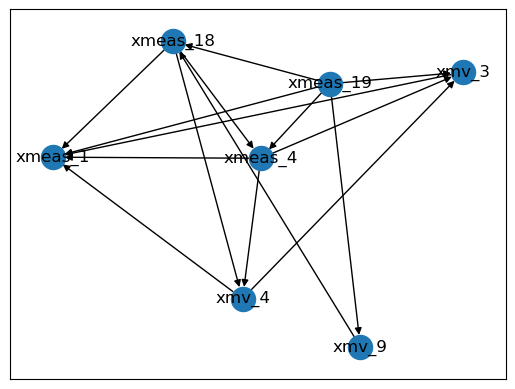

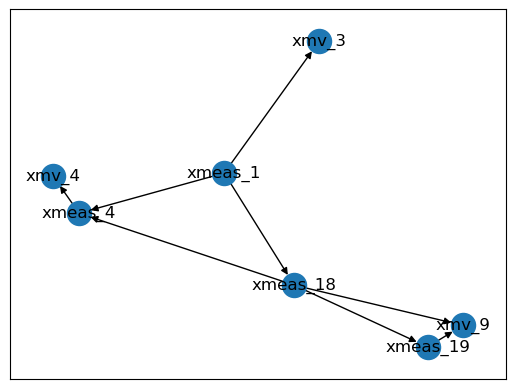

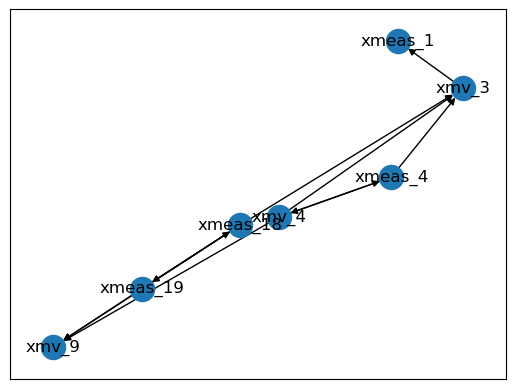

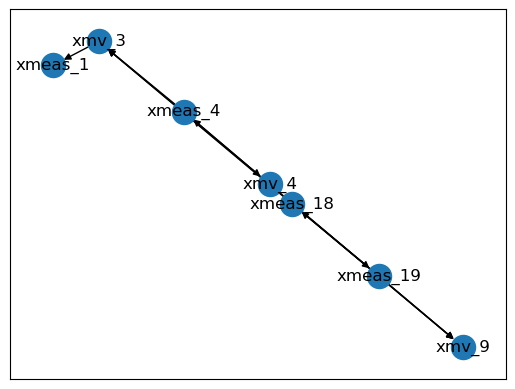

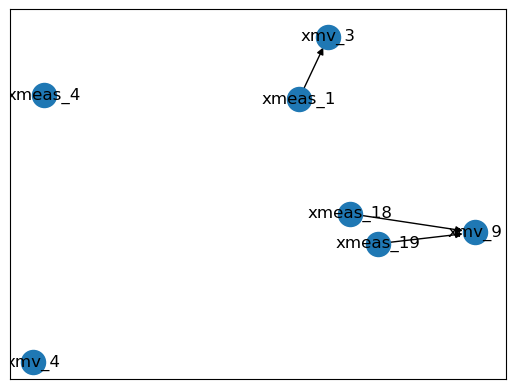

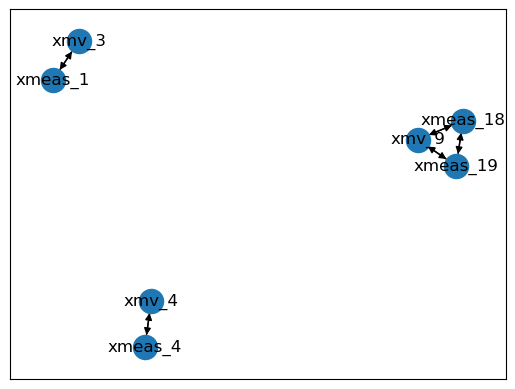

In [18]:
algorithms = [ cdt.causality.graph.CAM() # 2 mins
             , cdt.causality.graph.CCDr()
             , cdt.causality.graph.GES()
             , cdt.causality.graph.GIES()
             , cdt.causality.graph.LiNGAM()
             , cdt.causality.graph.PC()]
nalgo = len(algorithms)
for i in range(nalgo):
    algo = str(algorithms[i]).split(sep='.')[3]
    print("algorithm:", algo)
    start = time.time()
    g = algorithms[i].predict(fault7)
    end = time.time()
    print("time elpased:", end - start)
    plt.figure(algo)
    nx.draw_networkx(g, with_labels=True)
plt.show()

In [51]:
from pgmpy.estimators import BayesianEstimator

# there are many choices of parametrization, here is one example
model = BayesianNetwork(dag.edges())
model.fit(
    df_train_normal, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts=0.1
)
model.get_cpds()

[<TabularCPD representing P(xmeas_1:482) at 0x1db1432ef50>,
 <TabularCPD representing P(xmv_7:490 | xmeas_1:482) at 0x1db14600a50>,
 <TabularCPD representing P(xmv_8:490 | xmv_7:490) at 0x1db149049d0>,
 <TabularCPD representing P(xmv_3:488 | xmv_7:490) at 0x1db149076d0>,
 <TabularCPD representing P(xmv_11:479 | xmv_7:490) at 0x1db149048d0>,
 <TabularCPD representing P(xmv_6:473 | xmv_7:490) at 0x1db14905650>,
 <TabularCPD representing P(xmeas_12:462 | xmv_7:490) at 0x1db14905750>,
 <TabularCPD representing P(xmv_4:471 | xmv_7:490) at 0x1db14905b90>,
 <TabularCPD representing P(xmeas_10:462 | xmv_7:490) at 0x1db14906050>,
 <TabularCPD representing P(xmeas_4:460 | xmv_7:490) at 0x1db149062d0>,
 <TabularCPD representing P(xmeas_14:455 | xmv_7:490) at 0x1db149065d0>,
 <TabularCPD representing P(xmeas_17:451 | xmv_7:490) at 0x1db14906990>,
 <TabularCPD representing P(xmv_10:446 | xmv_7:490) at 0x1db14906d90>,
 <TabularCPD representing P(xmeas_8:441 | xmv_7:490) at 0x1db14907450>,
 <TabularC

In [52]:
# Analyse distribution of variables, e.g. normally distributed with normality test like Anderson-Darling Test
from scipy.stats import anderson

# Create header for tabular output
print(f"{'DISTRIBUTION':<15}{'%sig':<10}{'stat':<12}{'crit-val':<10}"
      f"{'result':<10}\n")

# Loop through all continuous random variables and test them
for var in df_train_normal.columns:
    test = anderson(df_train_normal[var])
    # Loop through test results and unpack the sig.levels and crit-vals
    for i in range(len(test.critical_values)):
        sig_lev, cv = test.significance_level[i], test.critical_values[i]
        # Check if test.stat is < crit-val
        result = 'Fail to reject' if test.statistic < cv else 'Reject'
        # Print results in tabular format
        print(f"{var:<15}{sig_lev:<10}{test.statistic:<12.3f}{cv:<10}"
              f"{result:<10}")  
        if i is 4:
            print('\n')

DISTRIBUTION   %sig      stat        crit-val  result    

xmeas_1        15.0      0.661       0.571     Reject    
xmeas_1        10.0      0.661       0.651     Reject    
xmeas_1        5.0       0.661       0.781     Fail to reject
xmeas_1        2.5       0.661       0.911     Fail to reject
xmeas_1        1.0       0.661       1.083     Fail to reject


xmeas_2        15.0      0.634       0.571     Reject    
xmeas_2        10.0      0.634       0.651     Fail to reject
xmeas_2        5.0       0.634       0.781     Fail to reject
xmeas_2        2.5       0.634       0.911     Fail to reject
xmeas_2        1.0       0.634       1.083     Fail to reject


xmeas_3        15.0      0.828       0.571     Reject    
xmeas_3        10.0      0.828       0.651     Reject    
xmeas_3        5.0       0.828       0.781     Reject    
xmeas_3        2.5       0.828       0.911     Fail to reject
xmeas_3        1.0       0.828       1.083     Fail to reject


xmeas_4        15.0      0.33

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\paulo\AppData\Local\Temp\ipykernel_6696\859025840.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 4:
